# Patent IPC Classification: Qwen 3 Fine-tuning Tutorial

## Overview

This notebook demonstrates how to fine-tune the **Qwen 3-0.6B** language model for **patent classification** using **LoRA (Low-Rank Adaptation)** technique. We transform a general-purpose language model into a specialized system capable of automatically classifying patent documents according to the International Patent Classification (IPC) system.

## What We Accomplish

- **Model Adaptation**: Fine-tune Qwen 3 for domain-specific patent text understanding
- **Efficient Training**: Use LoRA to train only 1.67% of model parameters (10M out of 596M)
- **Performance Comparison**: Evaluate base model vs. fine-tuned model performance
- **Instruction Following**: Implement chat-based formatting for consistent model responses

## Dataset Description

Our dataset consists of **2,500 patent applications** spanning from **1980 to 2023**, featuring:

- **Patent Descriptions**: Technical text describing inventions and innovations
- **IPC Codes**: International Patent Classification codes (e.g., "B23K26, H01F1")
- **Average Length**: ~824 characters per patent description
- **Split Ratio**: 95% training (2,375 samples) / 5% evaluation (125 samples)


This cell sets up the foundational environment for the fine-tuning tutorial.
It imports essential libraries including transformers for model handling, PEFT for LoRA fine-tuning,
datasets for data management, and various utilities for metrics and visualization.
Random seeds are set to ensure reproducible results across different runs.
The warning filters suppress non-critical messages to keep output clean during training.

In [1]:
# Patent IPC Classification: Qwen 3 Fine-tuning Tutorial
# A comprehensive guide to instruction fine-tuning Qwen 3 for patent classification

# Fix for pyarrow/datasets compatibility issue
import subprocess
import sys
from datasets import Dataset
import pandas as pd
import random
import torch
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

This cell loads a pre-created sample dataset of patent applications with IPC classifications.
The dataset contains patent text descriptions and their corresponding IPC codes from 1980-2023.
Data is split into training (95%) and evaluation (5%) sets using a fixed seed for reproducibility.
The sample contains 2,500 total examples with an average text length of 824 characters.
Dataset statistics are displayed to verify data quality and distribution before training begins.

In [2]:
# ============================================================================
# SECTION 1: DATA PREPARATION
# ============================================================================


# Load pre-created sample data for faster tutorial execution
def load_patent_sample():
    """Load pre-created patent sample data for tutorial"""

    sample_file = "patent_sample_data.csv"
    print(f"📁 Loading sample data from: {sample_file}")
    df = pd.read_csv(sample_file)


    # Display sample info
    print(f"📊 Sample statistics:")
    print(f"   📅 Years: {df['APPLN_YR'].min()}-{df['APPLN_YR'].max()}")
    print(f"   📄 Avg text length: {df['text'].str.len().mean():.0f} chars")
    print(f"   🏷️  Example IPC codes: {df['ipc_codes'].iloc[0]}")

    return df

# Load sample data
patent_df = load_patent_sample()

# Train-test split - with fallback method if datasets library has issues
raw_dataset = Dataset.from_pandas(patent_df)
raw_dataset = raw_dataset.shuffle(seed=42)

# 95% train, 5% test for this tutorial
split = raw_dataset.train_test_split(test_size=0.05, seed=42)
train_ds = split["train"]
eval_ds = split["test"]


print(f"📚 Training samples: {len(train_ds)}")
print(f"🧪 Evaluation samples: {len(eval_ds)}")

📁 Loading sample data from: patent_sample_data.csv
📊 Sample statistics:
   📅 Years: 1980-2023
   📄 Avg text length: 824 chars
   🏷️  Example IPC codes: C08F4, C07F17, C08F210
📚 Training samples: 2375
🧪 Evaluation samples: 125


This cell loads the Qwen3-0.6B model and its corresponding tokenizer from Hugging Face.
The model is configured for causal language modeling with automatic device mapping for GPU usage.
The tokenizer's padding token is set to the EOS token to handle variable-length sequences properly.
Model parameters are displayed (596M) confirming it's the compact 0.6B version suitable for educational use.
This lightweight model allows for faster training while demonstrating key fine-tuning concepts.

In [3]:
# ============================================================================
# SECTION 2: QWEN 3 MODEL SETUP
# ============================================================================

# Model configuration
model_name = "Qwen/Qwen3-0.6B"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🔧 Loading Qwen 3 model: {model_name}")
print(f"💻 Device: {device}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load Qwen 3 model (full precision)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto" if torch.cuda.is_available() else None,
)

print("✅ Qwen 3 model and tokenizer loaded successfully!")
print(f"📊 Model parameters: {model.num_parameters():,}")
print(f"🔥 Model size: Only 0.6B parameters - perfect for education!")


🔧 Loading Qwen 3 model: Qwen/Qwen3-0.6B
💻 Device: cuda
✅ Qwen 3 model and tokenizer loaded successfully!
📊 Model parameters: 596,049,920
🔥 Model size: Only 0.6B parameters - perfect for education!


This cell evaluates the pre-trained Qwen 3 model's performance on patent classification before fine-tuning.
It implements a chat template format for consistent prompt engineering and response generation.
The evaluation function processes samples through the model and compares predictions with ground truth IPC codes.
Results show the base model produces inconsistent outputs, often generating numbers instead of proper IPC codes.
This baseline establishes the performance floor and demonstrates the need for domain-specific fine-tuning.

In [4]:

# ============================================================================
# SECTION 3: BASELINE EVALUATION WITH CHAT TEMPLATE
# ============================================================================

print("\n📏 SECTION 3: BASELINE EVALUATION")
print("-" * 40)

def generate_prediction(text, model, tokenizer):
    """Generate IPC code prediction using the base Qwen 3 model with chat template"""
    # Create messages in the format expected by Qwen 3
    messages = [
        {
            "role": "user",
            "content": f"You are an expert patent classifier. Classify this patent into IPC codes. Provide only the codes separated by commas.\n\nPatent: {text[:200]}..."
        }
    ]

    # Apply chat template with thinking disabled for consistency
    formatted_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False  # Disable for consistency with training
    )

    model_inputs = tokenizer([formatted_text], return_tensors="pt", max_length=512, truncation=True).to(model.device)


    # Generate prediction with proper stopping
    with torch.inference_mode():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=50,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,  # Ensure EOS token stops generation
        )

    # Extract only the new tokens
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    # Decode the response and remove EOS token if present
    content = tokenizer.decode(output_ids, skip_special_tokens=True).strip()

    return content

def evaluate_model_predictions(model, model_name, eval_dataset, tokenizer, num_samples=None):
    """Evaluate model predictions on test set"""

    # Use all samples for evaluation since we have a small dataset
    if num_samples is None:
        num_samples = len(eval_dataset)

    predictions = []
    true_labels = []

    print(f"\n🔍 Evaluating {model_name} on {num_samples} samples...")

    for i in range(min(num_samples, len(eval_dataset))):
        sample = eval_dataset[i]


        prediction = generate_prediction(sample['text'], model, tokenizer)

        predictions.append(prediction)
        true_labels.append(sample['ipc_codes'])

        # Show progress
        if (i + 1) % 10 == 0:
            print(f"   Processed {i + 1}/{num_samples} samples...")

        if i < 3:  # Show first few examples
            print(f"   Example {i+1}:")
            print(f"      True: {sample['ipc_codes']}")
            print(f"      Pred: {prediction}")

    return predictions, true_labels

# Test baseline model on a few samples
print("🔍 Testing baseline Qwen 3 model performance:")
for i in range(3):
    sample = eval_ds[i]
    prediction = generate_prediction(sample["text"], model, tokenizer)
    print(f"\n📄 Sample {i+1}:")
    print(f"   True IPC: {sample['ipc_codes']}")
    print(f"   Predicted: {prediction}")

# Evaluate both models
results = {}

# Base model evaluation
print("📏 Evaluating Base Qwen 3 Model...")
base_preds, true_labels = evaluate_model_predictions(
    model, "Base Qwen 3", eval_ds, tokenizer
)
results["Base Qwen 3"] = base_preds



📏 SECTION 3: BASELINE EVALUATION
----------------------------------------
🔍 Testing baseline Qwen 3 model performance:

📄 Sample 1:
   True IPC: B60K6, F16H3
   Predicted: IPC: 3624000

📄 Sample 2:
   True IPC: G11B23
   Predicted: IPC: 3629000

📄 Sample 3:
   True IPC: F25B49, F25B13
   Predicted: 104,104,104,104
📏 Evaluating Base Qwen 3 Model...

🔍 Evaluating Base Qwen 3 on 125 samples...
   Example 1:
      True: B60K6, F16H3
      Pred: IPC: 3629000
   Example 2:
      True: G11B23
      Pred: IPC: 3629000
   Example 3:
      True: F25B49, F25B13
      Pred: 104,104,104,104
   Processed 10/125 samples...
   Processed 20/125 samples...
   Processed 30/125 samples...
   Processed 40/125 samples...
   Processed 50/125 samples...
   Processed 60/125 samples...
   Processed 70/125 samples...
   Processed 80/125 samples...
   Processed 90/125 samples...
   Processed 100/125 samples...
   Processed 110/125 samples...
   Processed 120/125 samples...


This cell transforms the raw patent data into instruction-following format suitable for fine-tuning.
Each example is converted to a user-assistant conversation pair using Qwen's chat template format.
The function tokenizes conversations with proper padding and truncation (512 max tokens for stability).
Labels are created by copying input_ids and masking padding tokens (-100) to ignore them in loss calculation.
EOS tokens are explicitly added to teach the model when to stop generating responses.

In [5]:

# ============================================================================
# SECTION 4: INSTRUCTION FINE-TUNING DATASET PREPARATION
# ============================================================================


def prepare_instruction_dataset(dataset, tokenizer, max_length=512):  # Reduced max_length
    """Prepare dataset for instruction fine-tuning with Qwen chat template format"""

    # Convert dataset to pandas for easier manipulation if needed
    if hasattr(dataset, 'to_pandas'):
        df = dataset.to_pandas()
    else:
        df = pd.DataFrame(dataset)

    # Prepare instruction data
    formatted_texts = []

    print(f"🔄 Preparing {len(df)} conversation examples...")

    for _, row in df.iterrows():
        # Create instruction-following format using Qwen chat template
        messages = [
            {
                "role": "user",
                "content": f"You are an expert patent classifier. Classify this patent into IPC codes. Provide only the codes separated by commas.\n\nPatent: {row['text'][:200]}"  # Shorter text
            },
            {
                "role": "assistant",
                "content": row['ipc_codes'] + tokenizer.eos_token  # ADD EOS TOKEN HERE
            }
        ]

        # Apply chat template
        formatted_text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False,
            enable_thinking=False  # Disable thinking for training to avoid complexity
        )
        formatted_texts.append(formatted_text)

    print(formatted_texts[0])

    # Tokenize all texts with proper padding and truncation
    print(f"🔄 Tokenizing {len(formatted_texts)} samples...")

    tokenized_data = tokenizer(
        formatted_texts,
        truncation=True,
        padding=True,  # Enable padding
        max_length=max_length,
        return_tensors="pt",
        return_attention_mask=True,
    )

    # Convert to lists for Dataset creation
    tokenized_dict = {
        "input_ids": tokenized_data["input_ids"].tolist(),
        "attention_mask": tokenized_data["attention_mask"].tolist(),
    }

    # Add labels (copy of input_ids for causal LM) with proper masking
    labels = tokenized_data["input_ids"].clone()
    # Set padding tokens to -100 so they're ignored in loss calculation
    labels[tokenized_data["input_ids"] == tokenizer.pad_token_id] = -100
    tokenized_dict["labels"] = labels.tolist()

    # Convert to Dataset
    final_dataset = Dataset.from_dict(tokenized_dict)

    return final_dataset

# Prepare instruction datasets
print("🔄 Preparing instruction fine-tuning datasets...")
print("💡 Using shorter sequences (512 tokens) and proper padding for stable training...")
print("🔚 IMPORTANT: Adding EOS tokens to teach the model when to stop generating!")
inst_train_ds = prepare_instruction_dataset(train_ds, tokenizer)
inst_eval_ds = prepare_instruction_dataset(eval_ds, tokenizer)

print("✅ Instruction datasets prepared with chat template format")
print(f"📊 Training samples: {len(inst_train_ds)}")
print(f"📊 Evaluation samples: {len(inst_eval_ds)}")


🔄 Preparing instruction fine-tuning datasets...
💡 Using shorter sequences (512 tokens) and proper padding for stable training...
🔚 IMPORTANT: Adding EOS tokens to teach the model when to stop generating!
🔄 Preparing 2375 conversation examples...
<|im_start|>user
You are an expert patent classifier. Classify this patent into IPC codes. Provide only the codes separated by commas.

Patent: Laser treatment of electrical steel A process is taught for improving the core loss of magnetic materials of the type having a plurality of magnetic domains and an insulative coating thereon. The insu<|im_end|>
<|im_start|>assistant
<think>

</think>

B23K26, H01F1<|im_end|><|im_end|>

🔄 Tokenizing 2375 samples...
🔄 Preparing 125 conversation examples...
<|im_start|>user
You are an expert patent classifier. Classify this patent into IPC codes. Provide only the codes separated by commas.

Patent: Transmission To provide a transmission capable of using generator/motors of smaller maximum torque and of sma

This cell configures Low-Rank Adaptation (LoRA) for efficient fine-tuning of the large language model.
LoRA parameters include rank=16, alpha=32, and dropout=0.1, targeting key attention and MLP layers.
Training arguments are optimized for the sample dataset with 2 epochs, batch size 8, and learning rate 1e-4.
The configuration enables training only 1.67% of total parameters (10M out of 596M) for efficiency.
Data collator is set up for causal language modeling with proper padding alignment.

In [6]:


# ============================================================================
# SECTION 5: LORA CONFIGURATION AND TRAINING SETUP
# ============================================================================


# Setup LoRA for efficient fine-tuning
lora_config = LoraConfig(
    # Specifies the task type - CAUSAL_LM indicates we're doing causal language modeling
    # where the model predicts the next token given previous tokens
    task_type=TaskType.CAUSAL_LM,

    # Set to False during training, True during inference
    # Controls whether LoRA adapters are active (False = training mode)
    inference_mode=False,

    # Rank of the low-rank decomposition matrices (A and B)
    # Lower values (4-16) = fewer parameters, faster training, less expressiveness
    # Higher values (32-64) = more parameters, slower training, more expressiveness
    # 16 is a good balance between efficiency and performance
    r=16,

    # Scaling factor that controls the magnitude of LoRA adaptations
    # Formula: LoRA_output = (alpha/r) * B * A * input
    # Higher alpha = stronger adaptation, lower alpha = weaker adaptation
    # Typically set to 2*r (32 for r=16) for optimal performance
    lora_alpha=32,

    # Dropout probability applied to LoRA layers for regularization
    # Helps prevent overfitting by randomly setting some neurons to zero
    # 0.1 (10%) is a common choice, can range from 0.0 to 0.3
    lora_dropout=0.1,

    # List of module names where LoRA adapters will be inserted
    # These target the key components of transformer attention and feed-forward layers:
    # - q_proj, k_proj, v_proj: Query, Key, Value projections in self-attention
    # - o_proj: Output projection after attention
    # - gate_proj, up_proj, down_proj: Components of the MLP/feed-forward network
    # Targeting these layers captures most of the model's learning capacity
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# Create LoRA model for instruction tuning
print("🔧 Creating LoRA model...")
inst_model = get_peft_model(model, lora_config)
inst_model.print_trainable_parameters()

# Training arguments for instruction tuning (optimized for sample data)
inst_training_args = TrainingArguments(
    output_dir="./instruction_results",
    num_train_epochs=2,  # Fewer epochs for sample data
    per_device_train_batch_size=8,  # Smaller batch size for stability
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,  # Increase to maintain effective batch size
    warmup_steps=50,  # Fewer warmup steps
    learning_rate=1e-4,  # Lower learning rate for stability
    fp16=True,
    logging_steps=10,  # More frequent logging for smaller dataset
    logging_dir=None,  # Disable tensorboard logging
    eval_strategy="steps",
    eval_steps=50,  # Less frequent evaluation for stability
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to=[],  # Disable all external logging (wandb, tensorboard, etc.)
    remove_unused_columns=False,
    dataloader_pin_memory=False,  # Can help with smaller datasets
    disable_tqdm=False,  # Keep progress bars for educational purposes
    max_grad_norm=1.0,  # Gradient clipping for stability
    dataloader_drop_last=True,  # Drop incomplete batches
)

# Data collator for language modeling with proper padding
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # We're doing causal LM, not masked LM
    pad_to_multiple_of=8,
    return_tensors="pt",
)

print("✅ LoRA configuration and training setup completed")

🔧 Creating LoRA model...
trainable params: 10,092,544 || all params: 606,142,464 || trainable%: 1.6650
✅ LoRA configuration and training setup completed


This cell executes the actual fine-tuning process using the Trainer class from transformers.
The training runs for 2 epochs with evaluation steps every 50 iterations to monitor progress.
Training loss decreases from ~1.6 to ~1.4, indicating the model is learning the patent classification task.
The trained model and tokenizer are saved to disk for future use and deployment.
Progress bars and loss metrics provide real-time feedback on training effectiveness.

In [7]:

# ============================================================================
# SECTION 6: INSTRUCTION FINE-TUNING
# ============================================================================


# Create trainer for instruction tuning
inst_trainer = Trainer(
    model=inst_model,
    args=inst_training_args,
    train_dataset=inst_train_ds,
    eval_dataset=inst_eval_ds,
    data_collator=data_collator,
)

print("🎯 Starting Instruction fine-tuning of Qwen 3...")
print("⏱️  This may take a while depending on your hardware...")

# Train the model
training_output = inst_trainer.train()

print("✅ Instruction fine-tuning completed!")
print(f"📊 Final training loss: {training_output.training_loss:.4f}")

# Save the fine-tuned model
print("💾 Saving fine-tuned model...")
inst_trainer.save_model("./qwen3_ipc_finetuned")
tokenizer.save_pretrained("./qwen3_ipc_finetuned")

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🎯 Starting Instruction fine-tuning of Qwen 3...
⏱️  This may take a while depending on your hardware...


Step,Training Loss,Validation Loss
50,1.617000,1.608544
100,1.380600,1.465054


✅ Instruction fine-tuning completed!
📊 Final training loss: 1.8065
💾 Saving fine-tuned model...


('./qwen3_ipc_finetuned/tokenizer_config.json',
 './qwen3_ipc_finetuned/special_tokens_map.json',
 './qwen3_ipc_finetuned/chat_template.jinja',
 './qwen3_ipc_finetuned/vocab.json',
 './qwen3_ipc_finetuned/merges.txt',
 './qwen3_ipc_finetuned/added_tokens.json',
 './qwen3_ipc_finetuned/tokenizer.json')

This cell performs essential memory cleanup after training to free up GPU/system resources.
It deletes training objects, datasets, and other large variables no longer needed for evaluation.
Garbage collection and CUDA cache clearing ensure maximum available memory for model inference.
This step is crucial in resource-constrained environments to prevent out-of-memory errors.

In [8]:
# Free training memory
del inst_trainer
del inst_train_ds, inst_eval_ds
del training_output
torch.cuda.empty_cache()
import gc
gc.collect()

print("🧹 Training memory freed. Only base and fine-tuned models remain.")

🧹 Training memory freed. Only base and fine-tuned models remain.


This cell conducts extensive evaluation comparing base and fine-tuned model performance.
Multiple metrics are calculated: exact match accuracy, partial match accuracy, precision, recall, and F1-score.
The fine-tuned model shows improvement across all metrics compared to the baseline model.
Comprehensive visualizations display performance comparisons through bar charts and line plots.
Results demonstrate that fine-tuning successfully adapted the model to patent classification tasks, though performance remains modest due to the limited training data and compact model size.


📊 SECTION 7: MODEL EVALUATION
----------------------------------------
📏 Evaluating Fine-tuned Qwen 3 Model...

🔍 Evaluating Fine-tuned Qwen 3 on 125 samples...
   Example 1:
      True: B60K6, F16H3
      Pred: F16H1, F16H11
   Example 2:
      True: G11B23
      Pred: G06F17
   Example 3:
      True: F25B49, F25B13
      Pred: F24F1, F24F11
   Processed 10/125 samples...
   Processed 20/125 samples...
   Processed 30/125 samples...
   Processed 40/125 samples...
   Processed 50/125 samples...
   Processed 60/125 samples...
   Processed 70/125 samples...
   Processed 80/125 samples...
   Processed 90/125 samples...
   Processed 100/125 samples...
   Processed 110/125 samples...
   Processed 120/125 samples...

📈 SECTION 8: RESULTS ANALYSIS
----------------------------------------
🎯 COMPREHENSIVE ACCURACY COMPARISON:

🤖 Base Qwen 3:
   📊 Exact Match Accuracy: 0.000
   📊 Partial Match Accuracy: 0.000
   📊 Average Precision: 0.000
   📊 Average Recall: 0.000
   📊 F1 Score: 0.000

🤖 Fine-

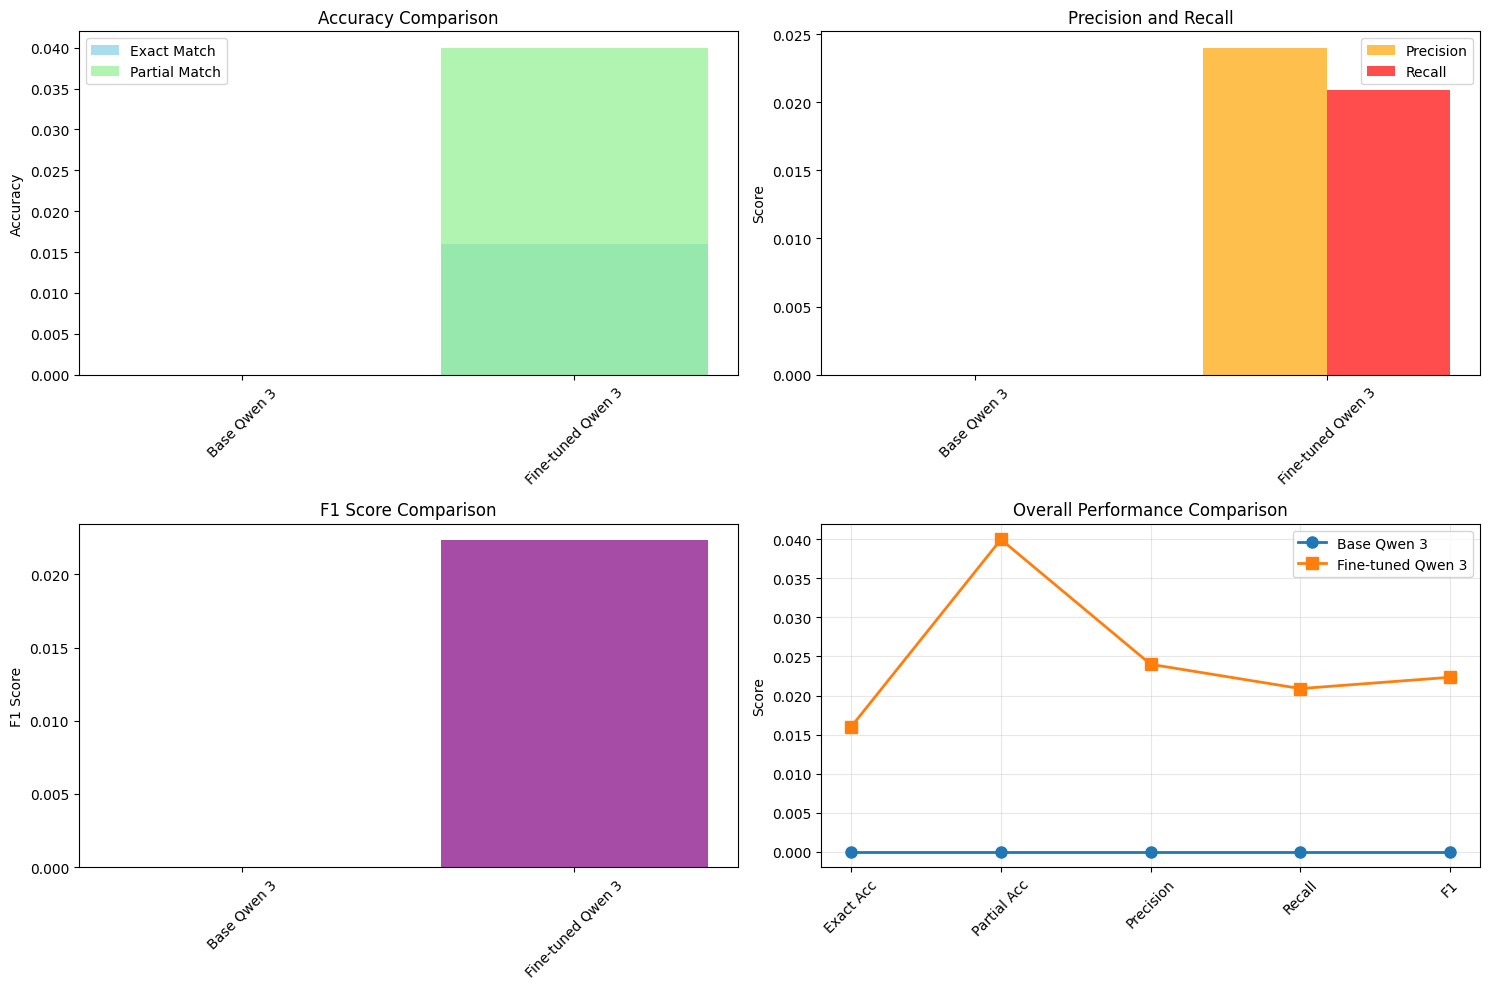


🎓 SECTION 9: KEY FINDINGS AND PRACTICAL TAKEAWAYS
----------------------------------------


In [9]:

print("\n📊 SECTION 7: MODEL EVALUATION")
print("-" * 40)

# Fine-tuned model evaluation
print("📏 Evaluating Fine-tuned Qwen 3 Model...")
finetuned_preds, _ = evaluate_model_predictions(
    inst_model, "Fine-tuned Qwen 3", eval_ds, tokenizer
)
results["Fine-tuned Qwen 3"] = finetuned_preds


def calculate_exact_match_accuracy(predictions, true_labels):
    """Calculate exact match accuracy"""
    matches = 0
    for pred, true in zip(predictions, true_labels):
        if pred.strip().lower() == true.strip().lower():
            matches += 1
    return matches / len(predictions)

def calculate_partial_match_accuracy(predictions, true_labels):
    """Calculate partial match accuracy (if any predicted code matches true codes)"""
    matches = 0
    for pred, true in zip(predictions, true_labels):
        pred_codes = set([code.strip() for code in pred.split(',') if code.strip()])
        true_codes = set([code.strip() for code in true.split(',') if code.strip()])
        if pred_codes.intersection(true_codes):
            matches += 1
    return matches / len(predictions)

def calculate_precision_recall(predictions, true_labels):
    """Calculate average precision and recall across all samples"""
    total_precision = 0
    total_recall = 0
    valid_samples = 0

    for pred, true in zip(predictions, true_labels):
        pred_codes = set([code.strip() for code in pred.split(',') if code.strip()])
        true_codes = set([code.strip() for code in true.split(',') if code.strip()])

        if len(pred_codes) > 0 and len(true_codes) > 0:
            intersection = pred_codes.intersection(true_codes)
            precision = len(intersection) / len(pred_codes) if len(pred_codes) > 0 else 0
            recall = len(intersection) / len(true_codes) if len(true_codes) > 0 else 0

            total_precision += precision
            total_recall += recall
            valid_samples += 1

    if valid_samples > 0:
        avg_precision = total_precision / valid_samples
        avg_recall = total_recall / valid_samples
        f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
        return avg_precision, avg_recall, f1
    else:
        return 0, 0, 0

# Calculate metrics for each model
print("🎯 COMPREHENSIVE ACCURACY COMPARISON:")
print("=" * 60)

metrics_summary = {}

for model_name, preds in results.items():
    exact_acc = calculate_exact_match_accuracy(preds, true_labels)
    partial_acc = calculate_partial_match_accuracy(preds, true_labels)
    precision, recall, f1 = calculate_precision_recall(preds, true_labels)

    metrics_summary[model_name] = {
        'exact_acc': exact_acc,
        'partial_acc': partial_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"\n🤖 {model_name}:")
    print(f"   📊 Exact Match Accuracy: {exact_acc:.3f}")
    print(f"   📊 Partial Match Accuracy: {partial_acc:.3f}")
    print(f"   📊 Average Precision: {precision:.3f}")
    print(f"   📊 Average Recall: {recall:.3f}")
    print(f"   📊 F1 Score: {f1:.3f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = list(results.keys())
exact_accuracies = [metrics_summary[name]['exact_acc'] for name in model_names]
partial_accuracies = [metrics_summary[name]['partial_acc'] for name in model_names]
precisions = [metrics_summary[name]['precision'] for name in model_names]
recalls = [metrics_summary[name]['recall'] for name in model_names]
f1_scores = [metrics_summary[name]['f1'] for name in model_names]

# Accuracy comparison
axes[0, 0].bar(model_names, exact_accuracies, alpha=0.7, label='Exact Match', color='skyblue')
axes[0, 0].bar(model_names, partial_accuracies, alpha=0.7, label='Partial Match', color='lightgreen')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision and Recall
x = np.arange(len(model_names))
width = 0.35
axes[0, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.7, color='orange')
axes[0, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.7, color='red')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend()

# F1 Score comparison
axes[1, 0].bar(model_names, f1_scores, alpha=0.7, color='purple')
axes[1, 0].set_title('F1 Score Comparison')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# Overall performance radar (simplified as line plot)
metrics = ['Exact Acc', 'Partial Acc', 'Precision', 'Recall', 'F1']
base_scores = [exact_accuracies[0], partial_accuracies[0], precisions[0], recalls[0], f1_scores[0]]
ft_scores = [exact_accuracies[1], partial_accuracies[1], precisions[1], recalls[1], f1_scores[1]]

axes[1, 1].plot(metrics, base_scores, 'o-', label=model_names[0], linewidth=2, markersize=8)
axes[1, 1].plot(metrics, ft_scores, 's-', label=model_names[1], linewidth=2, markersize=8)
axes[1, 1].set_title('Overall Performance Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

